In [2]:
import numpy as np
import os
import pickle
from tqdm import tqdm
import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, add, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Bidirectional
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

In [2]:
base_dir = r"D:\Ammar's\Datasets\VizWiz\VizWiz Dataset"
train_img_dir = os.path.join(base_dir, 'train')
val_img_dir = os.path.join(base_dir, 'val')
test_img_dir = os.path.join(base_dir, 'test')
train_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'train.json')
val_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'val.json')
test_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'test.json')

In [3]:
import json

with open(train_annot_dir, 'r') as file:
    train_dict = json.load(file)

with open(val_annot_dir, 'r') as file:
    val_dict = json.load(file)

with open(test_annot_dir, 'r') as file:
    test_dict = json.load(file)

In [4]:
loaded_data_path = r"D:\Ammar's\Datasets\VizWiz\loaded_data"

In [5]:
import pickle 
pickle.dump(train_dict, open(os.path.join(loaded_data_path, 'train_dict.pkl'), 'wb'))
pickle.dump(val_dict, open(os.path.join(loaded_data_path, 'val_dict.pkl'), 'wb'))
pickle.dump(test_dict, open(os.path.join(loaded_data_path, 'test_dict.pkl'), 'wb'))

In [6]:
with open(os.path.join(loaded_data_path, 'train_dict.pkl'), 'rb') as f:
  train_dict = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_dict.pkl'), 'rb') as f:
  val_dict = pickle.load(f)
with open(os.path.join(loaded_data_path, 'test_dict.pkl'), 'rb') as f:
  test_dict = pickle.load(f)

In [5]:
train_img_mapping = {}

for indiv_dict in train_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    train_img_mapping[img_name] = img_id

In [6]:
val_img_mapping = {}

for indiv_dict in val_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    val_img_mapping[img_name] = img_id

In [7]:
test_img_mapping = {}

for indiv_dict in test_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    test_img_mapping[img_name] = img_id

In [10]:
import pickle 
pickle.dump(train_img_mapping, open(os.path.join(loaded_data_path, 'train_img_mapping.pkl'), 'wb'))
pickle.dump(val_img_mapping, open(os.path.join(loaded_data_path, 'val_img_mapping.pkl'), 'wb'))

In [11]:
pickle.dump(test_img_mapping, open(os.path.join(loaded_data_path, 'test_img_mapping.pkl'), 'wb'))

In [5]:
with open(os.path.join(loaded_data_path, 'train_img_mapping.pkl'), 'rb') as f:
    train_img_mapping = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_img_mapping.pkl'), 'rb') as f:
    val_img_mapping = pickle.load(f)
with open(os.path.join(loaded_data_path, 'test_img_mapping.pkl'), 'rb') as f:
    test_img_mapping = pickle.load(f)

In [8]:
len(train_img_mapping)

23431

In [9]:
len(val_img_mapping)

7750

In [10]:
len(test_img_mapping)

8000

In [11]:
HEIGHT = 224
WIDTH = 224

shape = (HEIGHT, WIDTH, 3)

In [17]:
# Define VGG16 Model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
def get_features(model, split_set, set_dict):
    image_features = {}
    directory = os.path.join(base_dir, split_set)

    for img_name in tqdm(os.listdir(directory)):
        if not (img_name in set_dict.keys()): continue
        # Load an image
        img_path = os.path.join(directory, img_name)
        img = load_img(img_path, target_size=(HEIGHT, WIDTH))
        # Convert image into numpy pixel values
        img = img_to_array(img)
        # Reshape the data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        # Preprocess
        img = tf.keras.applications.resnet50.preprocess_input(img)
        # Extract features
        feature = model.predict(img, verbose=0)
        # Map img_id with its features
        img_id = set_dict[img_name]
        image_features[img_id] = feature
    return image_features

In [ ]:
train_img_features = get_features(model, 'train', train_img_mapping)
val_img_features = get_features(model, 'val', val_img_mapping)
test_img_features = get_features(model, 'test', test_img_mapping)

In [ ]:
train_img_features_path = os.path.join(loaded_data_path, 'train_img_features_vgg16.pkl')
val_img_features_path = os.path.join(loaded_data_path, 'val_img_features_vgg16.pkl')
test_img_features_path = os.path.join(loaded_data_path, 'test_img_features_vgg16.pkl')

In [ ]:
pickle.dump(test_img_features, open(test_img_features_path, 'wb'))
pickle.dump(train_img_features, open(train_img_features_path, 'wb'))
pickle.dump(val_img_features, open(val_img_features_path, 'wb'))

In [ ]:
with open(train_img_features_path, 'rb') as f:
    train_img_features = pickle.load(f)
with open(val_img_features_path, 'rb') as f:
    val_img_features = pickle.load(f)
with open(test_img_features_path, 'rb') as f:
    test_img_features = pickle.load(f)

In [21]:
def get_captions(img_name, dict_set):
    img_captions = []
    i = 1
    for d in dict_set['images']:
        encountered = False
        if d.get('file_name') == img_name:
            img_id = d.get('id')
            for k in dict_set['annotations']:
                if k.get('image_id') != img_id and encountered: break
                if k.get('image_id') == img_id:
                    encountered = True
                    if k.get('is_rejected') == False:
                        img_captions.append(k.get('caption'))
                 
    return img_captions

In [22]:
train_img_to_captions = {}

for img_name, img_id in tqdm(train_img_mapping.items()):
    if img_id not in train_img_to_captions:
        train_img_to_captions[img_id] = get_captions(img_name, train_dict)

pickle.dump(train_img_to_captions, open(os.path.join(loaded_data_path, 'train_img_to_captions.pkl'), 'wb'))

100%|██████████| 23431/23431 [05:04<00:00, 76.97it/s]


In [23]:
# Do it for validation
val_img_to_captions = {}

for img_name, img_id in tqdm(val_img_mapping.items()):
    if img_id not in val_img_to_captions:
        val_img_to_captions[img_id] = get_captions(img_name, val_dict)

pickle.dump(val_img_to_captions, open(os.path.join(loaded_data_path, 'val_img_to_captions.pkl'), 'wb'))

100%|██████████| 7750/7750 [00:33<00:00, 232.52it/s]


In [24]:
with open(os.path.join(loaded_data_path, 'train_img_to_captions.pkl'), 'wb') as f:
    pickle.dump(train_img_to_captions, f)
with open(os.path.join(loaded_data_path, 'val_img_to_captions.pkl'), 'wb') as f:
    pickle.dump(val_img_to_captions, f)

In [13]:
with open(os.path.join(loaded_data_path, 'train_img_to_captions.pkl'), 'rb') as f:
    train_img_to_captions = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_img_to_captions.pkl'), 'rb') as f:
    val_img_to_captions = pickle.load(f)

In [ ]:
img_features = dict(list(train_img_features.items()) + list(val_img_features.items()))

In [ ]:
train_img_features = []
val_img_features = []

In [14]:
def preprocess_text(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', '')
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [15]:
# Before preprocessing captions:
train_img_to_captions[0]

['ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.',
 'A green and white plastic condiment bottle containing Basil leaves.',
 'A bottle of spices in a plastic container laying on a surface.',
 'some basil leaves in a container on a counter']

In [16]:
# After preprocessing
preprocess_text(train_img_to_captions)
train_img_to_captions[0]

['startseq its is basil leaves container its contains the net weight too. endseq',
 'startseq green and white plastic condiment bottle containing basil leaves. endseq',
 'startseq bottle of spices in plastic container laying on surface. endseq',
 'startseq some basil leaves in container on counter endseq']

In [17]:
preprocess_text(val_img_to_captions)

In [18]:
img_to_captions = dict(list(train_img_to_captions.items()) + list(val_img_to_captions.items()))

In [19]:
# Get all vocabulary 

all_captions = []

for key in img_to_captions.keys():
    for caption in img_to_captions[key]:
        all_captions.append(caption)

len(all_captions)

151773

In [20]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20571

In [21]:
with open(os.path.join(loaded_data_path, 'vocab.pkl'), 'wb') as f:
  pickle.dump(tokenizer, f)

In [21]:
# get max length of a caption:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

150

IGNORE THE COMMENTS. MULTIPLE SPLITS WERE TRIED OUT AND EXPERIMENTED WITH

In [22]:
# Train test split
img_ids = list(img_to_captions.keys())
split_val = int(len(img_ids) * 0.9)
train = img_ids[:split_val]
# val = img_ids[split_val:]
test = img_ids[split_val:]
print(len(train), len(test))
# temp = train
# split = int(len(temp) * 0.9)
# train = temp[:split]
# test = temp[split:]

28062 3119


In [20]:
print(len(train), len(test), len(val))

23852 2651 4678


In [23]:
# create data generator to fetch imgs and captions (get data in batches)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # Encoding the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the seq into x, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store seqs
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
              x1, x2, y = np.array(x1), np.array(x2), np.array(y)
              yield [x1, x2], y
              x1, x2, y = list(), list(), list()
              n = 0   

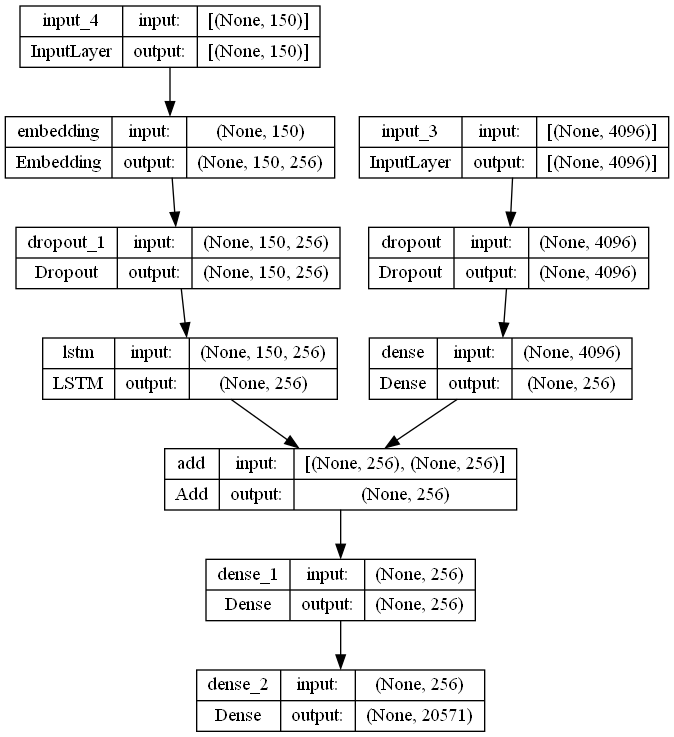

In [31]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=r'D:\VizWiz Dataset\loaded_models\vgg16_model.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min', verbose=1)

In [ ]:
epochs = 40
batch_size = 32
steps = len(train) // batch_size
val_steps = len(val) // batch_size

val_gen = data_generator(val, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        validation_data=val_gen, 
        validation_steps=val_steps, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1], 
        verbose=1)

In [36]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.4)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights(r'D:\VizWiz Dataset\loaded_models\vgg16_model.hdf5')
model.compile(optimizer='adam', loss='categorical_crossentropy', )

In [42]:
# generate captions
def idx_to_word(integer, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == integer: return word
    return None

In [41]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        next_word = model.predict([np.array(image), np.array(sequence)], verbose=0)
        next_word = np.argmax(next_word)
        word = idx_to_word(next_word, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq': break
    return in_text

Results for VGG16 + LSTM

In [39]:
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 2651/2651 [50:29<00:00,  1.14s/it]  


BLEU-1: 0.49141938816506914
BLEU-2: 0.33176431926372313


In [ ]:
# Visualize the results for VGG16

from PIL import Image
import matplotlib.pyplot as plt
import random

def pred_random_img(model):
    idx = random.randint(len(test_dict['images']))
    img_name = test_dict['images'][idx]['file_name']
    img_id = test_img_mapping[img_name]
    img_path = os.path.join(base_dir, 'test', img_name)
    img = Image.open(img_path)
    y_pred = predict_caption(model, test_img_features[img_id], tokenizer, max_length)
    print('-------------------------Predicted-----------------------------')
    print(y_pred)
    plt.imshow(img)

In [ ]:
pred_random_img(model)

# **VGG19**

In [40]:
# Define VGG19 Model
from tensorflow.keras.applications.vgg19 import VGG19
vgg_19 = VGG19()
vgg_19 = Model(inputs=vgg_19.inputs, outputs=vgg_19.layers[-2].output)
vgg_19.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
train_img_features = get_features(vgg_19, 'train', train_img_mapping)
val_img_features = get_features(vgg_19, 'val', val_img_mapping)
test_img_features = get_features(vgg_19, 'test', test_img_mapping)

In [ ]:
train_img_features_vgg19_path = os.path.join(loaded_data_path, 'train_img_features_vgg19.pkl')
val_img_features_vgg19_path = os.path.join(loaded_data_path, 'val_img_features_vgg19.pkl')
test_img_features_vgg19_path = os.path.join(loaded_data_path, 'test_img_features_vgg19.pkl')

pickle.dump(test_img_features, open(test_img_features_vgg19_path, 'wb'))
pickle.dump(train_img_features, open(train_img_features_vgg19_path, 'wb'))
pickle.dump(val_img_features, open(val_img_features_vgg19_path, 'wb'))

In [ ]:
train_img_features_vgg19_path = os.path.join(loaded_data_path, 'train_img_features_vgg19.pkl')
val_img_features_vgg19_path = os.path.join(loaded_data_path, 'val_img_features_vgg19.pkl')
test_img_features_vgg19_path = os.path.join(loaded_data_path, 'test_img_features_vgg19.pkl')

with open(train_img_features_vgg19_path, 'rb') as f:
    train_img_features = pickle.load(f)
with open(val_img_features_vgg19_path, 'rb') as f:
    val_img_features = pickle.load(f)
with open(test_img_features_vgg19_path, 'rb') as f:
    test_img_features = pickle.load(f)

In [ ]:
img_features = dict(list(train_img_features.items()) + list(val_img_features.items()))
img_to_captions = dict(list(train_img_to_captions.items()) + list(val_img_to_captions.items()))

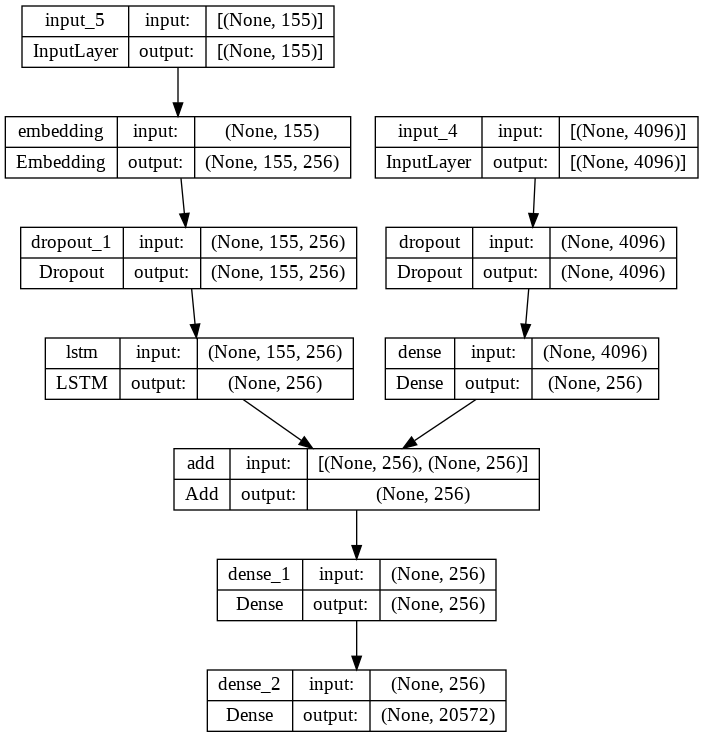

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding next
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=r'D:\VizWiz Dataset\loaded_models\vgg19_model.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
epochs = 40
batch_size = 32
steps = len(train) // batch_size
val_steps = len(val) // batch_size

val_gen = data_generator(val, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        validation_data=val_gen, 
        validation_steps=val_steps, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1], 
        verbose=1)

701/701 [==============================] - ETA: 0s - loss: 4.6927
Epoch 1: val_loss improved from inf to 5.19530, saving model to /content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5
701/701 [==============================] - ETA: 0s - loss: 3.7954
Epoch 1: val_loss improved from 5.19530 to 5.11256, saving model to /content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5
701/701 [==============================] - ETA: 0s - loss: 3.5000
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.2970
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.1400
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.0189
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 2.9265
Epoch 1: val_loss did not improve from 5.11256
701/701 [============================

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.4)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights('/content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5')
model.compile(optimizer='adam', loss='categorical_crossentropy', )

Results for VGG19 + LST

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 2495/2495 [54:09<00:00,  1.30s/it]


BLEU-1: 0.34753209778532124
BLEU-2: 0.23195570735436263


In [ ]:
# Visualize the results for VGG19 + LSTM
pred_random_img(model)

# **Resnet50**

In [24]:
from tensorflow.keras.optimizers import Adam
# Define Resnet Model
from tensorflow.keras.applications import ResNet50
resnet = ResNet50()
resnet = Model(inputs=resnet.inputs, outputs=resnet.layers[-2].output)
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
from tensorflow.keras import layers
path_to_glove_file = r"D:\VizWiz Dataset\glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
word_index = dict(zip(tokenizer.word_index, range(vocab_size)))

embedding_matrix = np.zeros((150, embedding_dim))
for word, i in word_index.items():
    if i == 150: break
    if i < max_length:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


embedding_layer = layers.Embedding(
    150,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Found 400000 word vectors.


In [25]:
train_img_features_resnet_path = os.path.join(loaded_data_path, 'train_img_features_resnet.pkl')
val_img_features_resnet_path = os.path.join(loaded_data_path, 'val_img_features_resnet.pkl')
test_img_features_resnet_path = os.path.join(loaded_data_path, 'test_img_features_resnet.pkl')

In [31]:
train_img_features = get_features(resnet, 'train', train_img_mapping)
val_img_features = get_features(resnet, 'val', val_img_mapping)
test_img_features = get_features(resnet, 'test', test_img_mapping)

pickle.dump(test_img_features, open(test_img_features_resnet_path, 'wb'))
pickle.dump(train_img_features, open(train_img_features_resnet_path, 'wb'))
pickle.dump(val_img_features, open(val_img_features_resnet_path, 'wb'))

100%|██████████| 8000/8000 [34:02<00:00,  3.92it/s]


In [26]:
with open(train_img_features_resnet_path, 'rb') as f:
    train_img_features = pickle.load(f)
with open(val_img_features_resnet_path, 'rb') as f:
    val_img_features = pickle.load(f)
with open(test_img_features_resnet_path, 'rb') as f:
    test_img_features = pickle.load(f)

In [27]:
img_features = dict(list(train_img_features.items()) + list(val_img_features.items()))
train_img_features = {}
val_img_features = {}

In [62]:
conv_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(None,), dtype="int64")
seq_inputs = embedding_layer(seq_inputs)
# se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding next
se2 = Dropout(0.5)(seq_inputs)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


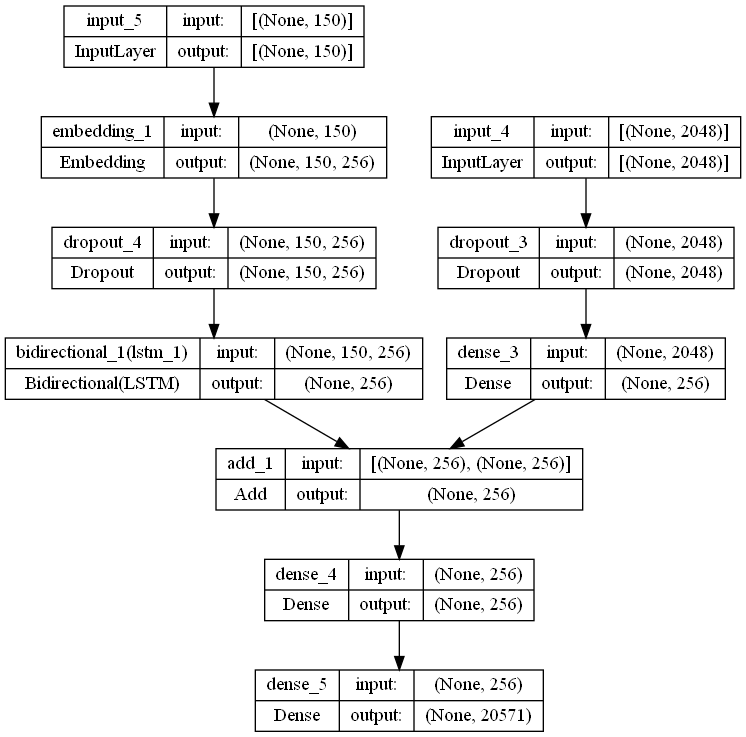

In [5]:
conv_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(150,))
se1 = Embedding(20571, 256, mask_zero=True)(seq_inputs) 
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(128))(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(20571, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [30]:
conv_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(128))(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights(os.path.join(loaded_models_path, "resnet_model.hdf5"))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [34]:
conv_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights(r"D:\VizWiz Dataset\loaded_models\resnet_model1_res.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
loaded_models_path = r"D:\Ammar's\Datasets\VizWiz"

In [32]:
from keras.callbacks import ModelCheckpoint

tl_checkpoint_1 = ModelCheckpoint(
    filepath=os.path.join(loaded_models_path, 'resnet_model2.hdf5'),              
    monitor='loss',
    mode='min',
    verbose=1,
    save_best_only=True
)
                                  

The following is not an error. It was interrupt on purpose. Since the model was starting to overfit, we had to stop it

In [37]:
epochs = 100
batch_size = 32
steps = len(train) // batch_size
# val_steps = len(val) // batch_size

# val_gen = data_generator(val, img_to_captions, img_features, tokenizer, 150, vocab_size, batch_size)

for i in range(epochs):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1], 
        verbose=1)                  

876/876 [==============================] - ETA: 0s - loss: 2.7142
Epoch 1: loss improved from inf to 2.71415, saving model to D:\Ammar's\Datasets\VizWiz\resnet_model2.hdf5
876/876 [==============================] - ETA: 0s - loss: 2.6359
Epoch 1: loss improved from 2.71415 to 2.63591, saving model to D:\Ammar's\Datasets\VizWiz\resnet_model2.hdf5
876/876 [==============================] - ETA: 0s - loss: 2.6073
Epoch 1: loss improved from 2.63591 to 2.60727, saving model to D:\Ammar's\Datasets\VizWiz\resnet_model2.hdf5
876/876 [==============================] - ETA: 0s - loss: 2.5855
Epoch 1: loss improved from 2.60727 to 2.58547, saving model to D:\Ammar's\Datasets\VizWiz\resnet_model2.hdf5
876/876 [==============================] - ETA: 0s - loss: 2.5673
Epoch 1: loss improved from 2.58547 to 2.56730, saving model to D:\Ammar's\Datasets\VizWiz\resnet_model2.hdf5
876/876 [==============================] - ETA: 0s - loss: 2.5532
Epoch 1: loss improved from 2.56730 to 2.55319, saving mod

KeyboardInterrupt: 

In [34]:
for i in range(20):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, 150, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        validation_data=val_gen, 
        validation_steps=val_steps, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1], 
        verbose=1)  

596/596 [==============================] - ETA: 0s - loss: 2.3628
Epoch 1: loss improved from 2.37113 to 2.36278, saving model to D:\VizWiz Dataset\loaded_models\resnet_model.hdf5
596/596 [==============================] - ETA: 0s - loss: 2.3562
Epoch 1: loss improved from 2.36278 to 2.35620, saving model to D:\VizWiz Dataset\loaded_models\resnet_model.hdf5
596/596 [==============================] - ETA: 0s - loss: 2.3491
Epoch 1: loss improved from 2.35620 to 2.34912, saving model to D:\VizWiz Dataset\loaded_models\resnet_model.hdf5
596/596 [==============================] - ETA: 0s - loss: 2.3411
Epoch 1: loss improved from 2.34912 to 2.34113, saving model to D:\VizWiz Dataset\loaded_models\resnet_model.hdf5
596/596 [==============================] - ETA: 0s - loss: 2.3351
Epoch 1: loss improved from 2.34113 to 2.33510, saving model to D:\VizWiz Dataset\loaded_models\resnet_model.hdf5
596/596 [==============================] - ETA: 0s - loss: 2.3282
Epoch 1: loss improved from 2.3351

ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  MemoryError: Unable to allocate 178. MiB for an array with shape (2262, 20571) and data type float32
Traceback (most recent call last):

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Ammar\AppData\Local\Temp\ipykernel_3488\2621830726.py", line 23, in data_generator
    x1, x2, y = np.array(x1), np.array(x2), np.array(y)

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 178. MiB for an array with shape (2262, 20571) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_10]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  MemoryError: Unable to allocate 178. MiB for an array with shape (2262, 20571) and data type float32
Traceback (most recent call last):

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Ammar\AppData\Local\Temp\ipykernel_3488\2621830726.py", line 23, in data_generator
    x1, x2, y = np.array(x1), np.array(x2), np.array(y)

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 178. MiB for an array with shape (2262, 20571) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_18312]

Assessing the performance of ResNet50 + LSTM

In [37]:
# Results for ResNet50 + LSTM
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 2651/2651 [37:37<00:00,  1.17it/s]


BLEU-1: 0.5981942090151174
BLEU-2: 0.4072047599550048


Assessing the performance of ResNet50 + BI-LSTM

In [43]:
# Results for ResNet50 + Bi-LSTM on 90 Epochs:
import nltk
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 3119/3119 [1:45:24<00:00,  2.03s/it]


BLEU-1: 0.6086578268434631
BLEU-2: 0.4156161074914101


Assessing ResNet50 + Bidirectional LSTM Trained on 50 Epochs

In [45]:
conv_inputs = Input(shape=(2048,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(128))(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights(r"D:\Ammar's\Datasets\VizWiz\resnet_50.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [46]:
# Results for ResNet50 + Bi-LSTM on 50 Epochs:

from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 3119/3119 [1:55:37<00:00,  2.22s/it]  


BLEU-1: 0.6016881148393616
BLEU-2: 0.4188710398887954
